In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import netCDF4 as nc
from scipy.integrate import solve_ivp
import matplotlib.animation as animation
#http://www-users.math.umn.edu/~mcgehee/Seminars/ClimateChange/presentations/2019-2Fall/20191001Handouts.pdf
#https://arxiv.org/pdf/1105.4918.pdf#:~:text=Budyko%2DSellers%20type%20EBMs%20model,energy%20emitted%20by%20the%20planet.&text=The%20state%20variable%20of%20a,to%20as%20a%20temperature%20profile.
#http://berkeleyearth.org/data-new/

In [2]:
#load and format data
def get_avg_lat_data():
    data = nc.Dataset('Land_and_Ocean_LatLong1.nc')
    #get the latitude values
    lat_vals = np.array(data['latitude'][:])
    time_vals = np.array(data['time'][:])
    time_ints = time_vals.astype(int)
    temp_array = np.array(data['temperature'][:])
    mask_semi_sphere = lat_vals > 0
    lat_vals_top = lat_vals[mask_semi_sphere]
    temp_array_top = temp_array[:,mask_semi_sphere,:]
    normal = np.array(data['climatology'][:])
    normal_top = normal[:,mask_semi_sphere,:]
    #get the year average
    unique_years = np.unique(time_ints)
    m,n,o = np.shape(temp_array_top)
    temp_array_new = np.zeros((len(unique_years), n, o))
    #create the groupby and average over the years
    for it, year in enumerate(unique_years):
        mask_year = time_ints == year
        if (year == 2020):
            new_year = temp_array_top[mask_year,:,:]+normal_top[:9,:,:]
        else:
            new_year = temp_array_top[mask_year,:,:]+normal_top
        mean_year = np.mean(new_year, axis=0)
        temp_array_new[it,:,:] = mean_year
    #now average the temp array over the latitudinal values
    temp_array_final = np.mean(temp_array_new,axis=2)
    #create the dataframe
    lat_vals_top = np.sin(np.deg2rad(lat_vals_top))
    all_time_data_frame = pd.DataFrame(data=temp_array_final, columns=lat_vals_top,index=unique_years)
    #create the 2020 dataframe
    temp_2020 = pd.DataFrame(data=temp_array_final[-1,:].flatten(), columns=['2020'], index=lat_vals_top)
    #save the dataframes
    temp_2020.to_csv('2020_mean_temp.csv')
    all_time_data_frame.to_csv('1850-2020_mean_temp.csv')

In [3]:
temp_lat_averaged = get_avg_lat_data()

<ipython-input-2-3d38833e9de5>:8: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  temp_array = np.array(data['temperature'][:])
<ipython-input-2-3d38833e9de5>:8: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  temp_array = np.array(data['temperature'][:])
<ipython-input-2-3d38833e9de5>:12: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  normal = np.array(data['climatology'][:])
<ipython-input-2-3d38833e9de5>:12: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  normal = np.array(data['climatology'][:])


### The Model

$$ R\frac{\partial T}{\partial t} = Qs(y)(1-\alpha(y))-(A+BT)+C(\bar{T}-T) $$

#### Equillibrium Temperature - Constant Albedo

<h5> What is Albedo? </h5>
<p> the measure of the diffuse reflection of solar radiation out of the total solar radiation and measured on a scale from 0, corresponding to a black body that absorbs all incident radiation, to 1, corresponding to a body that reflects all incident radiation </p>
<p> https://en.wikipedia.org/wiki/Albedo </p>

#### alpha_hat calculation

<h5> With the Chylek and Coakley's quadratic approximation </h5>

$$ s(y) \approx 1-0.241(3y^2-1) $$

$$\bar{\alpha} = \int_0^1 \alpha s(y)dy = \alpha \int_0^1 1-0.241(3y^2-1) dy$$
$$ = \alpha \int_0^1 1 dy - 0.241*3\alpha\int_0^1 y^2 dy + \alpha\int_0^1 0.241 dy $$
$$ \alpha - 0.241\alpha + 0.241\alpha = \alpha $$ 

In [4]:
def s(y):
    return 1 - 0.241*(3*np.square(y)-1)
def T_hat_star(B, alpha_hat, A, Q):
    return (1/B)*(Q*(1-alpha_hat)-A)
#generate the equillibrium profile based on parameters
def Gen_Equil_Temp_Prof(B,C,Q,s,alpha,A,T_hat_star):
    def equil_temp_prof(y):
        return ((1/(B+C))*(Q*s(y)*(1-alpha)-A+C*
            T_hat_star(B, alpha, A, Q)))
    return equil_temp_prof 
def alpha_function(y, eta, a_1, a_2):
    mask = y > eta
    y_new = np.copy(y)
    y_new[mask] = a_1
    y_new[~mask] = a_2
    return y_new
def alpha_hat(eta, a_1, a_2):
    return a_1 - (a_1-a_2)*(eta-0.241*(eta**3-eta))
def T_Hat_Star(A,B,Q,eta,a_1,a_2):
    return 1/B*(Q*(1-alpha_hat(eta, a_1, a_2))-A)
def T_eta_star(B,C,Q,A,y,a_1,a_2,eta):
    return 1/(B+C)*(Q*s(y)*(1-alpha_function(y,eta,a_1,a_2))-A
                +C*T_Hat_Star(A,B,Q,eta,a_1,a_2))

#### Equilibrium Temperature Profiles

<Figure size 432x288 with 0 Axes>

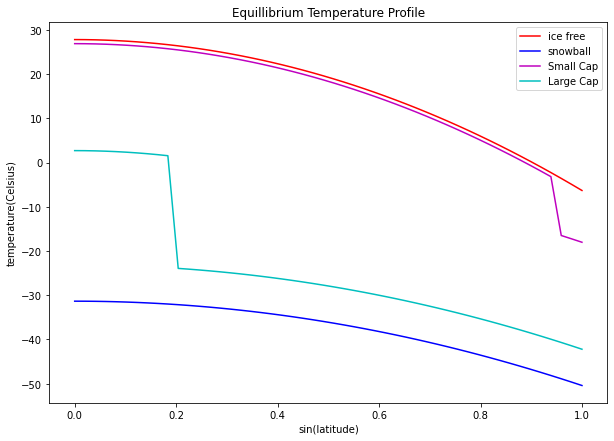

In [5]:
#define the constants
eta_1 = 0.95
eta_2 = 0.2
a_1 = 0.62
a_2 = 0.32
A = 202
B = 1.9
C = 1.6*B
Q = 343
y = np.linspace(0,1,50,endpoint=True)
#plot the equillibrium temperature
plt.clf()
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(y,Gen_Equil_Temp_Prof(B,C,Q,s,0.32,A,T_hat_star)(y),color='r', label='ice free')
ax.plot(y,Gen_Equil_Temp_Prof(B,C,Q,s,0.62,A,T_hat_star)(y),color='b',label='snowball')
ax.plot(y,T_eta_star(B,C,Q,A,y,a_1,a_2,eta_1),color='m', label='Small Cap')
ax.plot(y,T_eta_star(B,C,Q,A,y,a_1,a_2,eta_2),color='c', label='Large Cap')
ax.set_title("Equillibrium Temperature Profile")
ax.set_xlabel('sin(latitude)')
ax.set_ylabel('temperature(Celsius)')
plt.legend()
plt.show()

#### We are assuming symmetry. This means both semispheres (above the equator and below the equator) have symmetrical temperature patters, so the above graph really only represents the equllibrium temperature profile of one of the semispheres, but we are assuming it represents both.

<p> We have the equllibrium equation </p>
$$ T_n^*(y) = \frac{1}{B+C}(Qs(y)(1-\alpha(y,\eta))-A+C\bar{T}_{\eta}^*) $$
<p> And the critical equation </p>
$$ T_c = \frac{1}{2}(T_\eta^*(\eta+)+T_\eta^*(\eta-)) $$

<h5> We impose the condition $T_c = 0$ and then we get an ice line condtion equation that must be satisfied </h5> 
$$ h(\eta) = \frac{1}{B+C}(Qs(\eta)(1-a_0)-A+C\bar{T}_n^*)-T_c $$
$$ = \frac{Q}{B+C}(s(\eta)(1-a_0)+\frac{C}{B}(1-a_2+(a_2-a_1)S(\eta)))-\frac{A}{B} - T_c = 0 $$

In [6]:
def s(y):
    return 1-0.241*(3*np.square(y)-1)
def S(eta):
    return eta-0.241*(np.power(eta,3)-eta) 
def h(Q,A,B,C,T_c,eta,a_0,a_1,a_2):
    return Q/(B+C)*(s(eta)*(1-a_0)+C/B*(1-a_1+(a_1-a_2)*S(eta)))-A/B-T_c

#### Plot $h(\eta)$ to solve the satisfying values 

<Figure size 432x288 with 0 Axes>

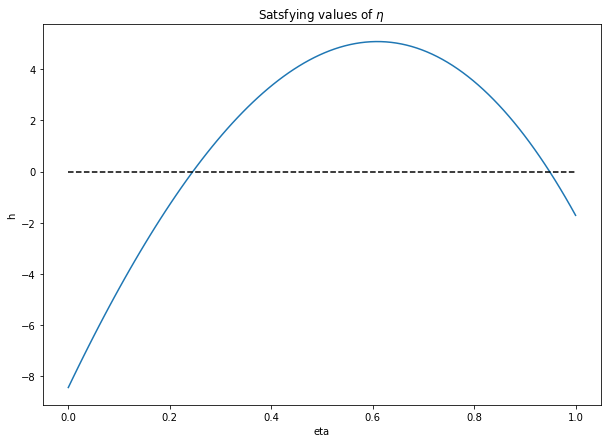

In [7]:
#set the vals
eta_vals = np.linspace(0,1,100)
a_1 = 0.62
a_2 = 0.32
a_0 = (a_1+a_2)/2
A = 202
B = 1.9
C = 1.6*B
Q = 343
T_c = -10
vals = h(Q,A,B,C,T_c,eta_vals,a_0,a_1,a_2)
plt.clf()
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(eta_vals, vals)
ax.plot(eta_vals, np.zeros_like(eta_vals), linestyle='dashed', color='k')
ax.set_xlabel('eta')
ax.set_ylabel('h')
ax.set_title("Satsfying values of $\eta$")
plt.show()

### Budyko-Widiasih Model

$$\frac{d\eta}{dt}=\epsilon h(\eta,A)  $$

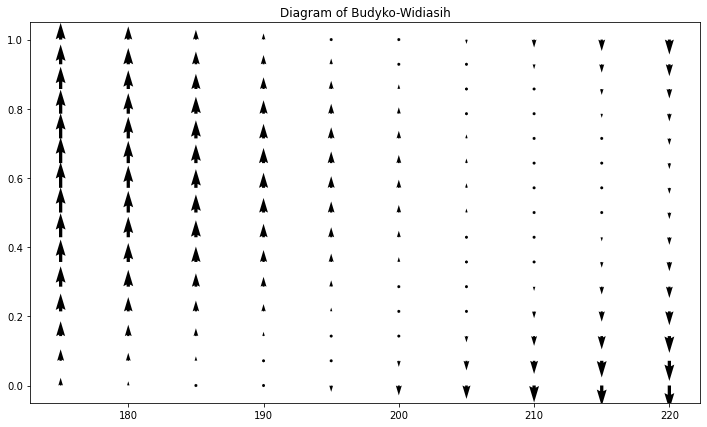

In [8]:
#set the constants
a_1 = 0.62
a_2 = 0.32
a_0 = (a_1+a_2)/2
A = 202
B = 1.9
C = 1.6*B
Q = 343
T_c = -10
#create the values
eta_vals = np.linspace(0,1,15)
A_vals = np.linspace(175, 220, 10)
epsilon = 0.01
#create the meshgrid
ETA, A = np.meshgrid(eta_vals, A_vals)
dETA = epsilon*h(Q,A,B,C,T_c,ETA,a_0,a_1,a_2)
dA = np.zeros_like(A)
#plot the grid
fig, ax = plt.subplots(figsize = (12, 7)) 
ax.quiver(A, ETA, dA, dETA, scale=5)
#plot the isocline
ax.set_title('Diagram of Budyko-Widiasih')
plt.show() 

<h3> Eventually we get the dynamical Equations - With Paleocarbon Equation </h3>
$$\frac{d\eta}{dt}=\epsilon h(\eta,A)  $$

$$\frac{dA}{dt} = \hat{\epsilon}(\eta-\eta_c) $$

$$ 0 < \hat{\epsilon} << \epsilon << 1 $$

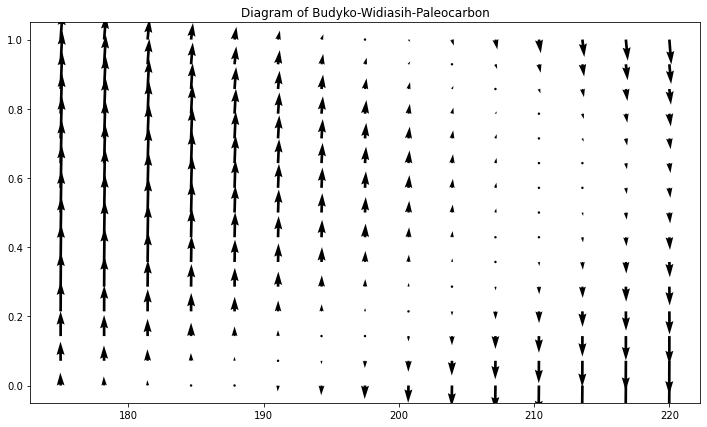

In [9]:
#set the constants
a_1 = 0.62
a_2 = 0.32
a_0 = (a_1+a_2)/2
A = 202
B = 1.9
C = 1.6*B
Q = 343
T_c = -10
eta_c = 0.15
#create the values
eta_vals = np.linspace(0,1,15)
A_vals = np.linspace(175, 220, 15)
epsilon = 0.1
eps_hat = 0.1
#create the meshgrid
ETA, A = np.meshgrid(eta_vals, A_vals)
dETA = epsilon*h(Q,A,B,C,T_c,ETA,a_0,a_1,a_2)
dA = eps_hat*(ETA-eta_c)
#plot the grid
fig, ax = plt.subplots(figsize = (12, 7)) 
ax.quiver(A, ETA, dA, dETA, scale=30)
ax.set_title('Diagram of Budyko-Widiasih-Paleocarbon')
#plot the isocline
#plt.legend()
plt.show() 

### Budyko-Sellers Model

$$\frac{d\eta}{dt}  = \epsilon(T(\eta) - T_c) $$
$$ \frac{dT}{dt} = \frac{1}{R} \left(Qs(y)(1-\alpha(y))-(A+BT)+C(\bar{T}-T)\right) $$

In [58]:
#create the phase portrait of the given model at a point y = 0.35
epsilon = 0.01
#set the constants
eta_init = 0.1
a_1 = 0.62
a_2 = 0.32
a_0 = (a_1+a_2)/2
A = 202
B = 1.9
C = 3.04
Q = 343
R = 12.6
#the single point the we are going to look at
T_c = -10
#get the initial T values and the y_values to plot from
temp_data = pd.read_csv('2020_mean_temp.csv', index_col=0)
T_init = temp_data['2020']
#fill the nan values with the average of nearest neighbors
T_init = T_init.fillna(method='ffill') + T_init.fillna(method='bfill')/2
#convert to numpy arrays
T_init = T_init.tolist()
T_init.append(eta_init)
T_init = np.array(T_init)
y_vals = temp_data.index.to_numpy()

### Define my own update function

In [59]:
def init_T(y):
    return 14-54*np.square(y)

In [60]:
y_vals = np.linspace(0,1,500)
#T_init with a design function (not the actual values)
T_init = init_T(y_vals)
T_init = T_init.tolist()
T_init.append(eta_init)
T_init = np.array(T_init)

In [61]:
def s(y):
    return 1 - 0.241*(3*np.square(y)-1)
def alpha_function(y, eta, a_1, a_2):
    mask = y > eta
    y_new = np.copy(y)
    y_new[mask] = a_1
    y_new[~mask] = a_2
    return y_new
def compute_global_mean(T):
    return np.mean(T)
def get_T_eta(eta):
    min_arg = np.argmin(np.absolute(y_vals-eta))
    return min_arg
def update_T(T_vals, eta):
    return 1/R*(Q*s(y_vals)*(1-alpha_function(y_vals, eta, 0.62, 0.32)) - (A+B*T_vals)
         + C*(compute_global_mean(T_vals) - T_vals))
def update(T,y):
    T_vals = y[:-1]
    eta = y[-1]
    new_T = update_T(T_vals, eta)
    eta_arg = get_T_eta(eta)
    T_eta_arg = T_vals[eta_arg]
    if (eta_arg < len(T_vals)-1 and eta_arg > 1):
        if (T_vals[eta_arg] > T_vals[eta_arg+1]):
            T_eta_arg = (T_vals[eta_arg]+T_vals[eta_arg+1])/2
        else:
            T_eta_arg = (T_vals[eta_arg]+T_vals[eta_arg-1])/2
    eta_update = epsilon*(T_eta_arg - T_c)
    return_list = [T_val for T_val in new_T]
    return_list.append(eta_update)
    return return_list

In [62]:
#time values
t = np.linspace(1,200,200,endpoint = True, dtype=int)
#now use the scipy solver
solution = solve_ivp(update, t_span=[0,200], y0 = T_init, t_eval=t)

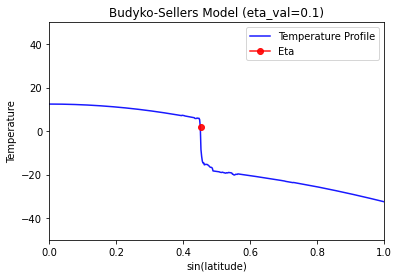

In [63]:
#animate the temperature solution
sol_vals = solution['y']
plt.ioff()
fig = plt.figure()
ax = fig.add_subplot(111)
traj, = ax.plot([],[], color='b', alpha=0.9, label='Temperature Profile')
eta, = ax.plot([],[],color='r', marker='o', alpha=0.9, label='Eta')
ax.set_xlabel("sin(latitude)")
ax.set_xlim([0,1])
ax.set_ylim([-50,50])
ax.set_ylabel("Temperature")
plt.legend()
ax.set_title("Budyko-Sellers Model (eta_val={})".format(eta_init))
def mation(i):
    traj.set_data(y_vals, sol_vals[:-1,i])
    eta_arg = get_T_eta(sol_vals[-1,i])
    T_eta = sol_vals[:-1, i][eta_arg]
    eta.set_data(sol_vals[-1,i],T_eta)
    return traj,eta
#create the animation
ani = animation.FuncAnimation(fig, mation, frames=range(200), interval=30)
#save the animation
ani.save('budyko-sellers-eta0_{}-epsilon_{}.mp4'.format(eta_init,epsilon))

<video src="budyko-sellers.mp4" controls>